<a href="https://colab.research.google.com/github/AnnaIsoyan/yelp/blob/main/yelp_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About Yelp

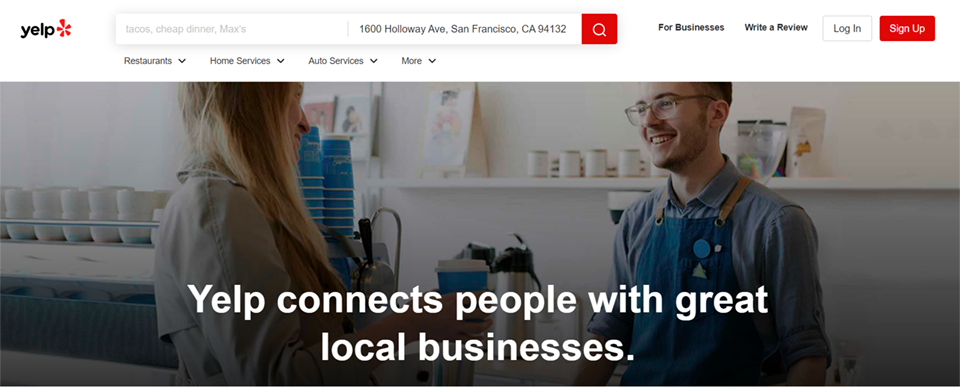

**What Is Yelp?**

Founded in 2004, Yelp is a popular online directory for discovering local businesses ranging from bars, restaurants, and cafes to hairdressers, spas, and gas stations.

**How Does Yelp Work?**

You can search Yelp via its **[website](https://www.yelp.com/)** or with the official apps on **iOS** and **Android** smart devices. Listings are sorted by business type and results are filtered by geographical location, price range, and unique features like outdoor seating, delivery service, or the ability to accept reservations.

Yelp has a strong social aspect and encourages its users to leave written reviews, star ratings, and photos of their experience with each business they visit.

Each Yelp account has a friends list that can be populated by connecting the app with Facebook and a smartphone or tablet's address book. Reviews posted on Yelp can also be reviewed by other users, while popular reviewers have the potential to be promoted to Yelp Elite status.

#About Dataset

**The Yelp dataset is a subset of Yelp businesses, reviews, and user data for use in personal, educational, and academic purposes. Available as JSON files, it can be used to teach students about databases, to learn NLP, or for sample production data.**

**Yelp organizes round of Dataset Challenges, however even there is no any competition now, the last updated data is available for interested people and can be downloaded [from the official web site](https://www.yelp.com/dataset), where you also can find a documentation for the data.**

#How I will deal with data

In Yelp official web site data is represented as tar file.

**What Is a TAR File?**

TAR file format is used to store multiple files in one single file, it's a popular method for both archiving purposes and for sending multiple files over the internet, like for software downloads.The TAR file format is common in Linux and Unix systems, but only for storing data, not compressing it.
A program or command that can open archives is needed to open a TAR file.
Finally, Python has module for tar file monipulations which I'll use successfully to get access all the project files

**Some conclusions about the data**


1.   I will use only some part of information, in particular
  *   **yelp_academic_dataset_business.json**
      containes information about business such as buisness initials, object  
      star, activity categories, total review counts
  *   **yelp_academic_dataset_review.json**
      contains user reviews for businesses in the form of stars, usefullness,
      etc., and review text
  *   **yelp_academic_dataset_user.json**
      containes information about the user - name, different kind of given
      review counts, friends list etc
2.   I will use some NLP techniques on user review texts to be sure if I need to consider that review

3. I will reject photo review part of the users

4. I have the location of businesses represented by lattitude and longitude, also I have business categories in yelp_academic_dataset_business file as objects for each business

5. Finally my ML model will reccommend best services arround due to user location and chosen business category based on hundreds of reviews of other users


#Modules

In [ ]:
import tarfile
import os
from os.path import exists
from google.colab import drive
import json
import urllib.request as urllib2
from pymongo import MongoClient

from sklearn.cluster import KMeans

import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

**Mount drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Extract tar file

**you must download the .tar file from yelp official web site and upload to your drive with this path**

*content/drive/MyDrive/ColabNotebooks/files/yelp_dataset.tar*

In [ ]:
class ExtractTar:
  def __init__(self, path):
     if not exists(path):
      raise ValueError("Wrong file path")

     self.__extract(path)

  def __extract(self, path):
    tar = tarfile.open(path)
    tar.extractall(path="/content/drive/MyDrive/ColabNotebooks/files/yelp_json")
    tar.close()

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/files/yelp_dataset.tar'

extractTar = ExtractTar(path)

#build dataframe from json

In [ ]:
def load_dataframe_from_path(name):
  folder_path = "/content/drive/MyDrive/ColabNotebooks/files/yelp_json"
  dir_list = os.listdir(folder_path)
  for file in dir_list:
    extracted = os.path.splitext(file)
    file_name = extracted[0]
    file_ext = extracted[1]

    if not file_ext == '.json':
      continue
    if not file_name.rsplit('_', 1)[-1] == name:
      continue
    file_path = folder_path + '/' + file
    df = pd.read_json(file_path, lines=True, encoding='utf-8')
    return df

#business_dataframe

In [ ]:
business_df = load_dataframe_from_path('business')
business_df.head()

business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [ ]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


**we can see that not all the businesses categorised, we have to delete uncategorised ones**

In [ ]:
business_df['categories'].isna().sum()

103

**drop unnecessary columns**

In [ ]:
business_df.drop(columns = ['attributes', 'postal_code', 'hours', 'address'], inplace=True)
business_df

business_id                      name           city state  \
0       Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  Santa Barbara    CA   
1       mpf3x-BjTdTEA3yCZrAYPw             The UPS Store         Affton    MO   
2       tUFrWirKiKi_TAnsVWINQQ                    Target         Tucson    AZ   
3       MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   Philadelphia    PA   
4       mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery     Green Lane    PA   
...                        ...                       ...            ...   ...   
150341  IUQopTMmYQG-qRtBk-8QnA              Binh's Nails       Edmonton    AB   
150342  c8GjPIOTGVmIemT7j5_SyQ      Wild Birds Unlimited      Nashville    TN   
150343  _QAMST-NrQobXduilWEqSw         Claire's Boutique   Indianapolis    IN   
150344  mtGm22y5c2UHNXDFAjaPNw  Cyclery & Fitness Center   Edwardsville    IL   
150345  jV_XOycEzSlTx-65W906pg                   Sic Ink   Apollo beach    FL   

         latitude   longitude  stars  review_count  is_open  \
0       34.426679 -119.711197    5.0             7        0   
1       38.551126  -90.335695    3.0            15        1   
2       32.223236 -110.880452    3.5            22        0   
3       39.955505  -75.155564    4.0            80        1   
4       40.338183  -75.471659    4.5            13        1   
...           ...         ...    ...           ...      ...   
150341  53.468419 -113.492054    3.0            13        1   
150342  36.115118  -86.766925    4.0             5        1   
150343  39.908707  -86.065088    3.5             8        1   
150344  38.782351  -89.950558    4.0            24        1   
150345  27.771002  -82.394910    4.5             9        1   

                                               categories  
0       Doctors, Traditional Chinese Medicine, Naturop...  
1       Shipping Centers, Local Services, Notaries, Ma...  
2       Department Stores, Shopping, Fashion, Home & G...  
3       Restaurants, Food, Bubble Tea, Coffee & Tea, B...  
4                               Brewpubs, Breweries, Food  
...                                                   ...  
150341                         Nail Salons, Beauty & Spas  
150342  Pets, Nurseries & Gardening, Pet Stores, Hobby...  
150343  Shopping, Jewelry, Piercing, Toy Stores, Beaut...  
150344  Fitness/Exercise Equipment, Eyewear & Optician...  
150345  Beauty & Spas, Permanent Makeup, Piercing, Tattoo  

[150346 rows x 10 columns]

**store and delete uncategorised items**

In [ ]:
_del_business_df = business_df[business_df["categories"].isna()].reset_index(drop=True)
business_df.dropna(subset=['categories'], inplace=True)
_del_business_df

business_id                                     name  \
0    SMYXOLPyM95JvZ-oqnsWUA             A A Berlin Glass & Mirror Co   
1    9ryVeDaaR-le3kiSayTGow  Pauline African Hair Braiding & Weaving   
2    xT3J-SP5g49g2FjQfLEQfg                           Luxury Perfume   
3    _obl2-rphXvtzP3y_ekV1Q                 Certegy Payment Services   
4    mKxCNYEoKt6d_1rXmvRwww                               Green Envy   
..                      ...                                      ...   
98   szluot9mpdIAnUDGi27__w                    Anchor Pools and Spas   
99   s54FBcv78I6QNjqznP9oKw      Superior Fence and Rail of Pinellas   
100  KYI2rHE3vTG_z9ddqhp58A       Tima Fashion African Hair Braiding   
101  DCvA43gLeetay_qttR9ABQ                   Cham-Pagne Salon & Spa   
102  NoU_2sLsdgUxAf9S7vuCQg                              Food Bazaar   

                 city state   latitude   longitude  stars  review_count  \
0              Berlin    NJ  39.800416  -74.937181    3.0             5   
1           Saint Ann    MO  38.726032  -90.379323    1.0             5   
2                Reno    NV  39.475623 -119.783350    2.0             5   
3    Saint Petersburg    FL  27.877463  -82.653546    1.0             7   
4       Saint Charles    MO  38.826533  -90.472224    1.5             5   
..                ...   ...        ...         ...    ...           ...   
98           Palmetto    FL  27.558259  -82.556160    2.5             5   
99              Largo    FL  27.903442  -82.762799    1.5            10   
100           Trenton    NJ  40.230251  -74.769697    1.0             5   
101        Barrington    NJ  39.869476  -75.052961    1.0             5   
102      Philadelphia    PA  39.948253  -75.166683    2.0             8   

     is_open categories  
0          1       None  
1          1       None  
2          1       None  
3          1       None  
4          1       None  
..       ...        ...  
98         1       None  
99         1       None  
100        1       None  
101        1       None  
102        0       None  

[103 rows x 10 columns]

**delete closed businesses**

In [ ]:
#business_df.drop(business_df.index[business_df['is_open'] == 0], inplace=True)

In [ ]:
business_df.shape

(150243, 11)

**business report by reviews**

In [ ]:
business_df.sort_values(by=['stars', 'review_count'], ascending=[False, False], inplace=True)
business_df[['name','stars', 'review_count', 'is_open']]

name  stars  review_count  is_open
12307                 Blues City Deli    5.0           991        1
134154               Carlillos Cocina    5.0           799        1
25015              Free Tours By Foot    5.0           769        1
16555                        Tumerico    5.0           705        1
70650                            Yats    5.0           623        1
...                               ...    ...           ...      ...
149823               4 Friends Moving    1.0             5        0
149832             PSI Testing Center    1.0             5        1
149944       Specialists PC Endocrine    1.0             5        1
149995              Papa John's Pizza    1.0             5        1
150139  National Property Inspections    1.0             5        1

[150243 rows x 4 columns]

**show business report by reviews**

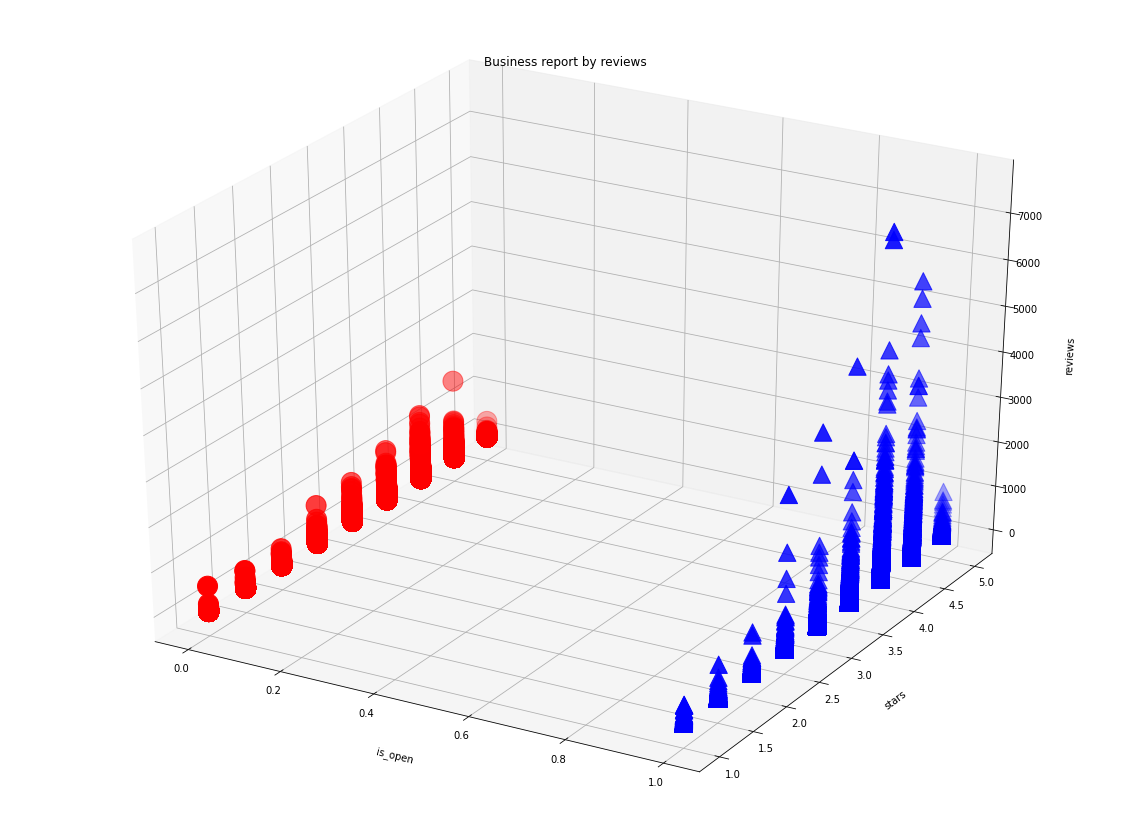

In [ ]:
fig = plt.figure(figsize = (20,15))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(business_df.loc[business_df['is_open'] == 0]['is_open'], business_df.loc[business_df['is_open'] == 0]['stars'], business_df.loc[business_df['is_open'] == 0]['review_count'], c = 'r', marker='o', s = 400)
ax.scatter(business_df.loc[business_df['is_open'] == 1]['is_open'], business_df.loc[business_df['is_open'] == 1]['stars'], business_df.loc[business_df['is_open'] == 1]['review_count'], c = 'b', marker='^', s = 300)
ax.set_title('Business report by reviews')

# Set axes label
ax.set_xlabel('is_open', labelpad=20)
ax.set_ylabel('stars', labelpad=20)
ax.set_zlabel('reviews', labelpad=20)

plt.show()

**show reviews by stars**

<Figure size 432x288 with 0 Axes>

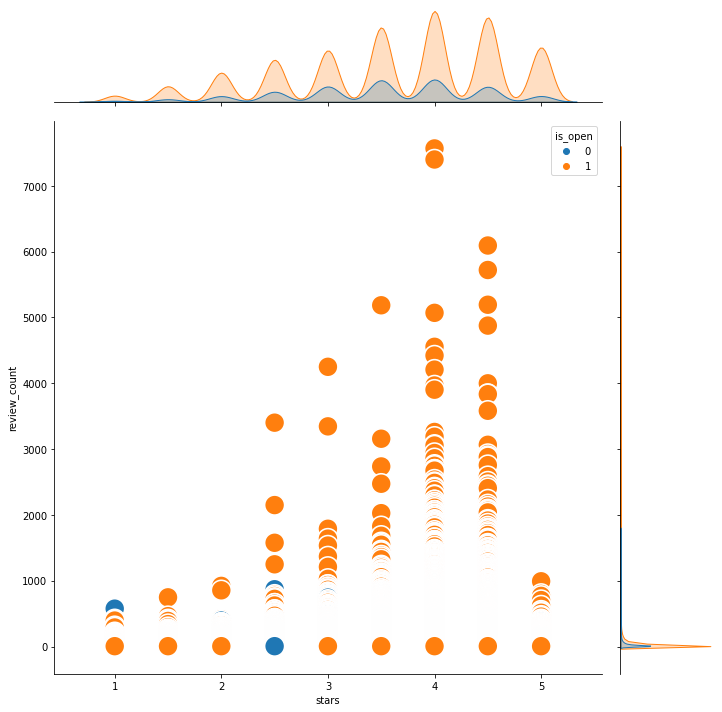

In [ ]:
plt.figure()
sns.jointplot(x = 'stars', y = 'review_count', data = business_df, hue='is_open', height=10, s = 400)
plt.show()

**business location  on the map**

In [ ]:
fig = px.density_mapbox(business_df, lat = 'latitude', lon = 'longitude', radius = 1,  zoom = 5, mapbox_style = 'stamen-terrain')

fig.show()

**business count by states**

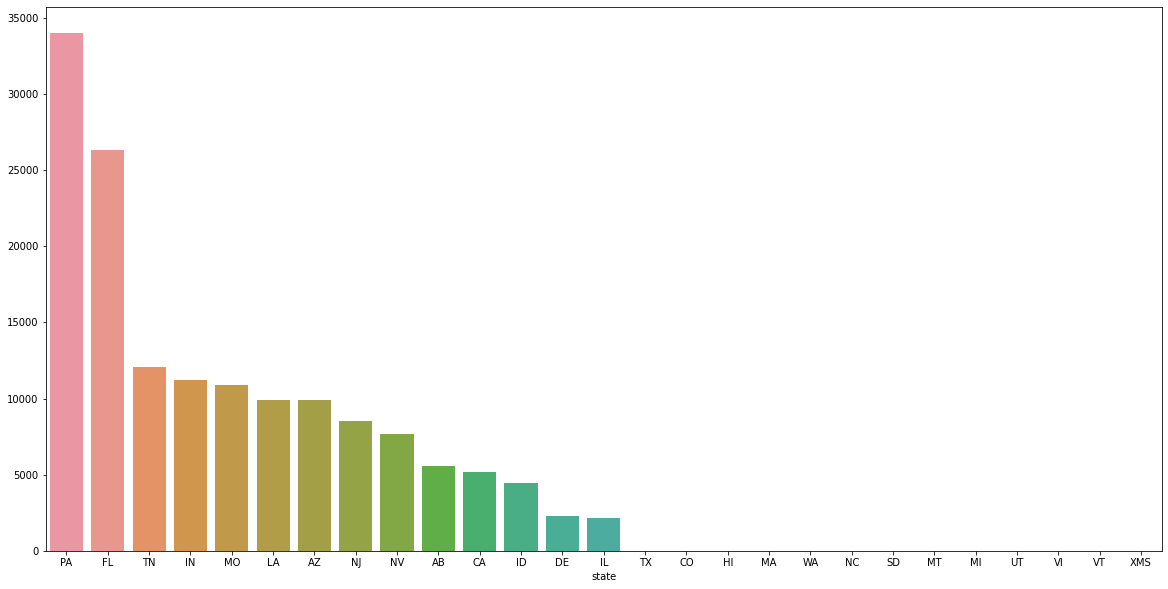

In [ ]:
business_cnt_states = business_df.groupby(['state'])['business_id'].count().sort_values(ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(x=business_cnt_states.index, y=business_cnt_states.values)
plt.show()

**opened and closed businesses**

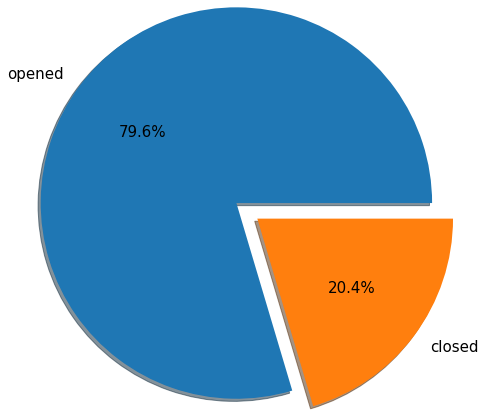

In [ ]:
opened_business_count = business_df[business_df['is_open'] == 1]['business_id'].count()
closed_business_count = business_df['business_id'].count() - opened_business_count

plt.figure(figsize = (10,6))
plt.pie([opened_business_count, closed_business_count], autopct='%1.1f%%', labels=['opened', 'closed'], shadow=True, radius=1.5, textprops={"fontsize": 15}, explode=[0.1, 0.1])
plt.show()

#some NLP on categories

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#from nltk.stem import PorterStemmer
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download([
     "stopwords",
     "wordnet",
     "averaged_perceptron_tagger",
     "omw-1.4",
     "punkt",
 ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def clean_sentence(sent, stopwords = stop_words, lemmatizer = lemmatizer):

  #tokenize words
  words_in_quote = word_tokenize(str(sent))

  #clean stopwords and all the symbols
  filtered_list = [
     word.lower().strip() for word in words_in_quote if word.casefold() not in stopwords and word.isalpha() and len(word)>1
  ]

  #lemmatize
  lemmatized_list = [
      lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_list
  ]

  #return cleaned text
  return ' '.join(lemmatized_list)

In [ ]:
business_df['categories'] = [clean_sentence(sent) for sent in business_df['categories']]

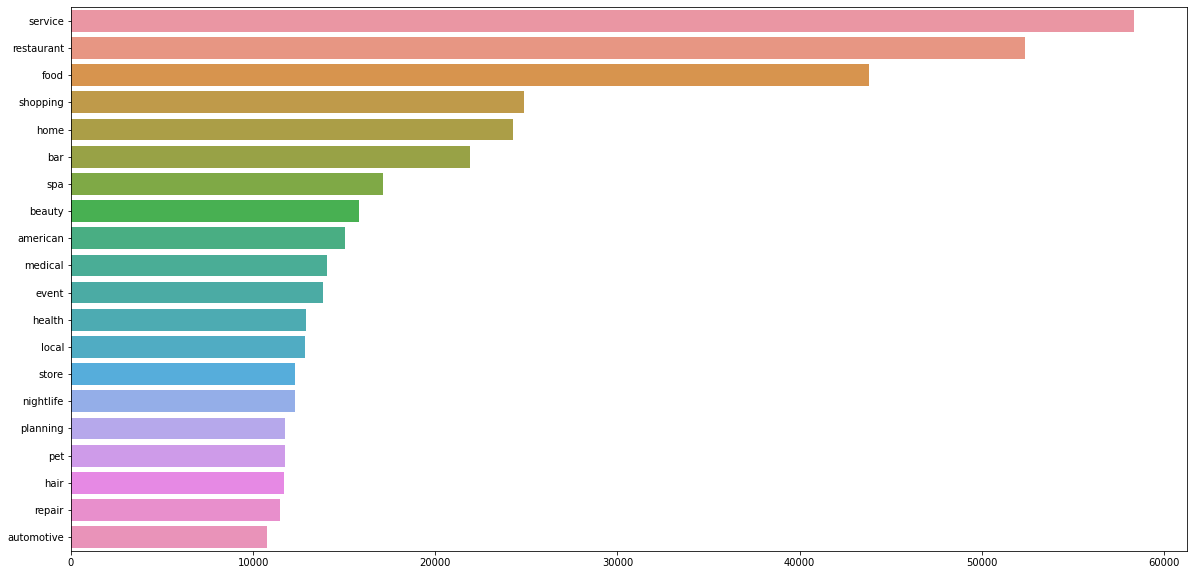

In [ ]:
category_count = {}
for categories in business_df["categories"]:
  cat_spl = str(categories).split()
  for cat in cat_spl:
    if cat not in category_count:
      category_count[cat] = 0
    category_count[cat] += 1

category_series = pd.Series(category_count)
category_series.sort_values(ascending = False, inplace = True)

plt.figure(figsize = (20,10))
sns.barplot(x=category_series[:20].values, y=category_series[:20].index)
plt.show()

#business_recommendation by location

**k-means**

In [ ]:
from sklearn.cluster import KMeans

**recommendation system by location**

***find the best k number***

In [ ]:
x = business_df[["longitude", "latitude"]]


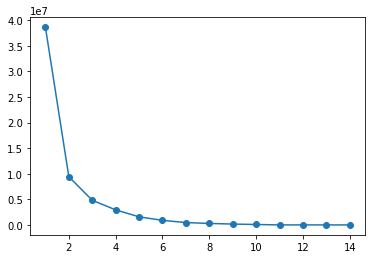

In [ ]:
wcss = []
r = range(1, 15)

for k in r:
  kmeans=KMeans(n_clusters=k, init="k-means++", max_iter=100).fit(x)
  wcss.append(kmeans.inertia_)


plt.plot(r, wcss, marker = 'o')
plt.show()




In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++')
labels = kmeans.fit_predict(x)

In [ ]:
u_labels = np.unique(labels)
u_labels

array([0, 1, 2, 3, 4], dtype=int32)

In [ ]:
business_df['cluster'] = kmeans.predict(x)
business_df.head()

business_id                name         city state  \
12307   _aKr7POnacW_VizRKBpCiA     Blues City Deli  Saint Louis    MO   
134154  8QqnRpM-QxGsjDNuu0E57A    Carlillos Cocina       Sparks    NV   
25015   zxIF-bnaJ-eKIsznB7yu7A  Free Tours By Foot  New Orleans    LA   
16555   DVBJRvnCpkqaYl6nHroaMg            Tumerico       Tucson    AZ   
70650   gP_oWJykA2RocIs_GurKWQ                Yats     Franklin    TN   

         latitude   longitude  stars  review_count  is_open  \
12307   38.605024  -90.218110    5.0           991        1   
134154  39.530096 -119.766608    5.0           799        1   
25015   29.925353  -90.079988    5.0           769        1   
16555   32.227705 -110.934722    5.0           705        1   
70650   35.948778  -86.818172    5.0           623        1   

                                               categories  cluster  
12307   Delis, Bars, Restaurants, Nightlife, Pubs, Ame...        0  
134154  Bars, Mexican, Breakfast & Brunch, Restaurants...        2  
25015               Hotels & Travel, Walking Tours, Tours        4  
16555   Mexican, Gluten-Free, Vegetarian, Restaurants,...        2  
70650   Cajun/Creole, Restaurants, Caterers, Comfort F...        0

In [ ]:
def recommend_by_location(data, longitude, latitude):
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)

    # Get the best restaurant in this cluster
    return  data[data['cluster']==cluster].iloc[0:5][['name', 'latitude','longitude', 'categories'	]]

In [ ]:
rec = recommend_by_location(business_df,-115.1891691,  36.1017316)
rec

1


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


name   latitude   longitude  \
134154         Carlillos Cocina  39.530096 -119.766608   
16555                  Tumerico  32.227705 -110.934722   
125597  Smiling With Hope Pizza  39.471879 -119.808947   
33175               Kaffe Crepe  39.504208 -119.782768   
148632               Buena Onda  34.424641 -119.686693   

                                               categories  
134154  Bars, Mexican, Breakfast & Brunch, Restaurants...  
16555   Mexican, Gluten-Free, Vegetarian, Restaurants,...  
125597                 Italian, Restaurants, Salad, Pizza  
33175   Food, Restaurants, Cafes, Creperies, Coffee & Tea  
148632  Event Planning & Services, Latin American, Cat...

In [ ]:
rec = recommend_by_location(business_df, -95.079988, 28.925353)
rec

2


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


name   latitude  longitude  \
25015                   Free Tours By Foot  29.925353 -90.079988   
144833  Barracuda Deli Cafe St. Pete Beach  27.736694 -82.748189   
7930                           Cafe Soleil  27.723416 -82.739291   
143760                          AJ's Press  27.973812 -82.496982   
63732             Two Chicks Walking Tours  29.930713 -90.076524   

                                               categories  
25015               Hotels & Travel, Walking Tours, Tours  
144833  Caribbean, Latin American, Restaurants, Breakf...  
7930    Restaurants, French, Coffee & Tea, Bakeries, B...  
143760  American (New), Cafes, Restaurants, Breakfast ...  
63732   Historical Tours, Arts & Entertainment, Archit...

In [ ]:
print(business_df['categories'][0])

Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists


#business_recommendation by categories for specific city

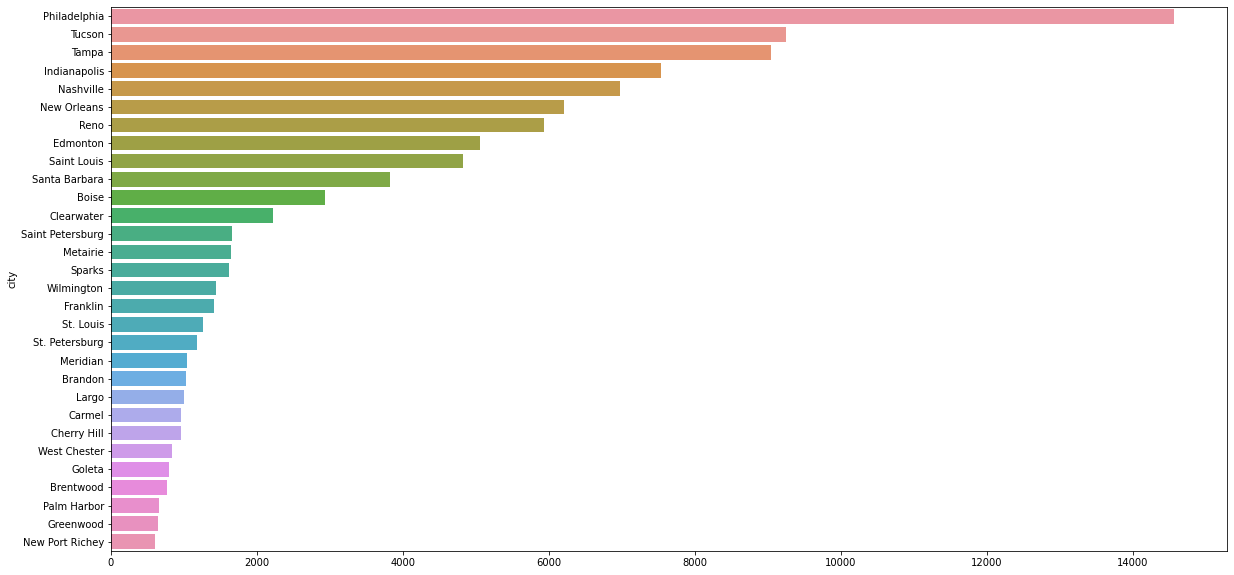

In [ ]:
business_cnt_city = business_df.groupby(['city'])['business_id'].count().sort_values(ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(x=business_cnt_city[:30].values, y=business_cnt_city[:30].index)
plt.show()

In [ ]:
philadelphia_df = business_df[business_df["city"] == 'Philadelphia']
philadelphia_df.reset_index(inplace = True, drop=True)
philadelphia_df

business_id                           name          city  \
0      l_7TW_Ix58-QvhQgpJi_Xw              SUGARED + BRONZED  Philadelphia   
1      u3zqvp4BYUjzJD7tzx3Jbg        JB Plumbing and Heating  Philadelphia   
2      qjGS_7iaQDpbVhS6W8qkHQ        The Sweet Life Bakeshop  Philadelphia   
3      Og4z8nB4ZMZs3oHkVhB_pA    Bobby Mack & Co Hair Studio  Philadelphia   
4      -fs09akgCKv5rTTy7iUHUg            ICI Macarons & Cafe  Philadelphia   
...                       ...                            ...           ...   
14555  w6WduajsiHjcFN4WxgRTkA      Brookmont Apartment Homes  Philadelphia   
14556  ujsFpiiGu92nUsjlFc9pew              Quest Diagnostics  Philadelphia   
14557  k_mIcCFvXWuN8I4ofCta3g                            KFC  Philadelphia   
14558  UILB1vgWi8cI5zhFnY4WUA  Worknet Occupational Medicine  Philadelphia   
14559  hcEOG4KamPIS1RfAATYH9w           Affordable Dentistry  Philadelphia   

      state   latitude  longitude  stars  review_count  is_open  \
0        PA  39.948570 -75.160072    5.0           513        1   
1        PA  39.955929 -75.157457    5.0           398        1   
2        PA  39.942203 -75.155223    5.0           316        1   
3        PA  39.944711 -75.174965    5.0           291        1   
4        PA  39.951910 -75.144381    5.0           276        1   
...     ...        ...        ...    ...           ...      ...   
14555    PA  40.107022 -75.039146    1.0             5        1   
14556    PA  40.004582 -75.217349    1.0             5        1   
14557    PA  40.012255 -75.135488    1.0             5        1   
14558    PA  40.028709 -75.209603    1.0             5        1   
14559    PA  39.925344 -75.171569    1.0             5        0   

                                              categories  
0      beauty spa shopping wax cosmetic beauty supply...  
1      plumbing water heater excavation service contr...  
2                            food cupcake dessert bakery  
3      hair salon men hair salon hair stylist beauty spa  
4      dessert bakery food coffee tea specialty food ...  
...                                                  ...  
14555                 real estate apartment home service  
14556  health medical diagnostic service medical cent...  
14557     restaurant chicken wing fast food chicken shop  
14558  medical center diagnostic service occupational...  
14559  dentist oral surgeon general dentistry cosmeti...  

[14560 rows x 10 columns]

In [ ]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(philadelphia_df["categories"])
matrix_array = count_matrix.toarray()
matrix_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
cosine_sim = cosine_similarity(count_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05832118],
       [0.        , 1.        , 0.        , ..., 0.        , 0.12598816,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.16666667, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.16666667, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.12598816, 0.        , ..., 0.        , 1.        ,
        0.23328474],
       [0.05832118, 0.        , 0.        , ..., 0.        , 0.23328474,
        1.        ]])

In [ ]:
Tfidf_vect = TfidfVectorizer()
vector_matrix = Tfidf_vect.fit_transform(philadelphia_df["categories"])
matrix_array = vector_matrix.toarray()
matrix_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
cosine_sim = cosine_similarity(vector_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04964297],
       [0.        , 1.        , 0.        , ..., 0.        , 0.02590737,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.04490397, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.04490397, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.02590737, 0.        , ..., 0.        , 1.        ,
        0.10866269],
       [0.04964297, 0.        , 0.        , ..., 0.        , 0.10866269,
        1.        ]])

In [ ]:
philadelphia_df['name'].head(10)

0                      SUGARED + BRONZED
1                JB Plumbing and Heating
2                The Sweet Life Bakeshop
3            Bobby Mack & Co Hair Studio
4                    ICI Macarons & Cafe
5      KC Carpet and Upholstery Cleaners
6                        Duross & Langel
7    City & Suburbs Pest Control Company
8                  Tortilleria San Roman
9                      Don's Auto Repair
Name: name, dtype: object

In [ ]:
philadelphia_df['categories'].head(10)

0    Beauty & Spas, Shopping, Waxing, Cosmetics & B...
1    Plumbing, Water Heater Installation/Repair, Ex...
2                   Food, Cupcakes, Desserts, Bakeries
3    Hair Salons, Men's Hair Salons, Hair Stylists,...
4    Desserts, Bakeries, Food, Coffee & Tea, Specia...
5    Grout Services, Home Cleaning, Carpet Cleaning...
6    Home & Garden, Personal Shopping, Beauty & Spa...
7    Local Services, Home Inspectors, Pest Control,...
8    Convenience Stores, Italian, Specialty Food, M...
9                              Automotive, Auto Repair
Name: categories, dtype: object

In [ ]:
def get_business_index(name, data = philadelphia_df):
  return data[data.name == name].index.values[0]
def get_category_index(cat, data = philadelphia_df):
  return data[[cat in c for c in list(data['categories'])]].index.values[0]
def get_name(index, data = philadelphia_df):
   return data[data.index == index]['name'].values[0]
def get_categories(index, data = philadelphia_df):
   return data[data.index == index]['categories'].values[0]

**recommendation by business_name**

In [ ]:
def get_recommendation_by_business(business_name, cosine_sim=cosine_sim):
    idx = get_business_index(business_name)

    similar_categories = list(enumerate(cosine_sim[idx]))
    similar_id_list = sorted(similar_categories, key=lambda x:x[1], reverse=True)[1:6]

    similar_object_list = []
    for id in similar_id_list:
      similar_object_list.append(
          {
              'business': get_name(id[0]),
              'categories': get_categories(id[0])
          }
      )

    return similar_object_list

In [ ]:
recs = get_recommendation_by_business('ICI Macarons & Cafe')
recs_df = pd.DataFrame(recs)
recs_df

business                                         categories
0            Sugar Philly        macarons specialty food food bakery dessert
1            Aurora Grace  macarons bakery chocolatiers shop food special...
2  Cake and the Beanstalk                     coffee tea food dessert bakery
3                     Oui                     bakery coffee tea dessert food
4            Jc Bake Shop                     bakery food coffee tea dessert

In [ ]:
recs = get_recommendation_by_business('Brookmont Apartment Homes')
recs_df = pd.DataFrame(recs)
recs_df

business  \
0  The Old Quaker Building by Reinhold Residential   
1                         2116 Chestnut Apartments   
2                               Dalian on the Park   
3                          The Station at Manayunk   
4                                    The St. James   

                           categories  
0  apartment real estate home service  
1  home service apartment real estate  
2  home service real estate apartment  
3  real estate home service apartment  
4  apartment home service real estate

**recommandation by category name**

In [ ]:
def get_recommendation_by_category(category_name, cosine_sim=cosine_sim):
    idx = get_category_index(category_name.casefold())

    similar_categories = list(enumerate(cosine_sim[idx]))
    similar_id_list = sorted(similar_categories, key=lambda x:x[1], reverse=True)[0:6]

    similar_object_list = []
    for id in similar_id_list:
      similar_object_list.append(
          {
              'business': get_name(id[0]),
              'categories': get_categories(id[0])
          }
      )
    return similar_object_list

In [ ]:
recs = get_recommendation_by_category('home cleaning')
recs_df = pd.DataFrame(recs)
recs_df

business  \
0  KC Carpet and Upholstery Cleaners   
1  Clear Reflection Cleaning Service   
2              Clenz Philly Cleaning   
3            Spots and Dots Cleaning   
4          Markel's Cleaning Service   
5               Philly Cleaning Pros   

                                          categories  
0  grout service home cleaning carpet cleaning lo...  
1  office cleaning home cleaning carpet cleaning ...  
2  office cleaning professional service carpet cl...  
3  local service professional service home cleani...  
4  professional service office cleaning local ser...  
5  home cleaning home service office cleaning car...

In [ ]:
recs = get_recommendation_by_category('Chicken')
recs_df = pd.DataFrame(recs)
recs_df

business                        categories
0  The Lucky Well - Spring Arts  chicken shop barbeque restaurant
1        Redcrest Fried Chicken           chicken shop restaurant
2                  Chick-A-Boom           chicken shop restaurant
3           Crown Fried Chicken           chicken shop restaurant
4        Crown Chicken & Burger           restaurant chicken shop
5     Popeyes Louisiana Kitchen      chicken shop restaurant food

#user_data_analyses

In [ ]:
user_df = load_dataframe_from_path('user')
user_df.head()

user_id    name  review_count        yelping_since  useful  \
0  7HJkaBB9XcBG8fFnBnA0BA  Brandi             2  2013-11-16 15:22:11       0   
1  pFhdbvetqceDwidlto7Xvg   Tracy             6  2015-09-05 18:04:51      10   
2  6pNRfCwkEEd8SCa4Y0UyQg   Tammy             3  2018-12-13 04:30:29       1   
3  p9BoIL_rElsGAQDLLWwErQ  Tricia             4  2011-04-17 23:33:23      10   
4  0xiXkpmSeunQp7EOIL9I2A     Ana             1  2015-03-07 02:10:57       0   

   funny  cool elite                                            friends  fans  \
0      0     0           VMwycj_9cmrbbkIt4y62LA, JL8LzituQ-ocr35MvS6pyA     0   
1      0     0        KPN4LEI1z2ioyWX01M05cw, cZ4m-STQKQujZbdglkgxjg...     0   
2      0     0        YgR1IfAWFSUBMiCFwObwlw, rpc5iRyp-ftzw5rwOhAUVQ...     0   
3      0     0        VMTfARHsCAvuwdIlejA5zg, pd9dfTwtUFGbCL3RCY5QTg...     1   
4      0     0        jCwvWiojVfoxAf1u6V27NA, jYyzXqPGqA-Ri5lsw1bGgg...     0   

   ...  compliment_more  compliment_profile  compliment_cute  compliment_list  \
0  ...                0                   0                0                0   
1  ...                0                   0                0                0   
2  ...                0                   0                0                0   
3  ...                0                   0                0                0   
4  ...                0                   0                0                0   

   compliment_note  compliment_plain  compliment_cool  compliment_funny  \
0                0                 0                0                 0   
1                0                 1                0                 0   
2                0                 0                0                 0   
3                0                 0                0                 0   
4                0                 0                0                 0   

   compliment_writer  compliment_photos  
0                  0                  0  
1                  0                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0  

[5 rows x 22 columns]

In [ ]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570164 entries, 0 to 570181
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             570164 non-null  object 
 1   name                570164 non-null  object 
 2   review_count        570164 non-null  int64  
 3   yelping_since       570164 non-null  object 
 4   useful              570164 non-null  int64  
 5   funny               570164 non-null  int64  
 6   cool                570164 non-null  int64  
 7   elite               570164 non-null  object 
 8   friends             570164 non-null  object 
 9   fans                570164 non-null  int64  
 10  average_stars       570164 non-null  float64
 11  compliment_hot      570164 non-null  int64  
 12  compliment_more     570164 non-null  int64  
 13  compliment_profile  570164 non-null  int64  
 14  compliment_cute     570164 non-null  int64  
 15  compliment_list     570164 non-nul

In [ ]:
user_df.shape

(570182, 22)

**delete records with less than 1 review**

In [ ]:
user_df.drop(user_df[(user_df.review_count < 1) & (user_df.useful < 1) & (user_df.funny < 1) & (user_df.cool < 1)].index, inplace=True)

**sort values**

In [ ]:
user_df = user_df[['user_id', 'name', 'review_count', 'useful', 'funny', 'cool', 'average_stars', 'elite', 'fans']]
user_df.sort_values(by=['review_count', 'useful'], ascending=[False, False], inplace=True)
user_df.reset_index(inplace=True)
user_df.head()

index                 user_id     name  review_count  useful  funny  \
0  373284  Ggx8iUdJ7lsQSqXRuclXtg   Nadine          3499  110553  77755   
1  371446  VgtcRwMPiAEeuPsayXB4kA      Max          2204     852    449   
2  208533  FdPioXvctMq8lhBtd_NnTg    Lilly          2173   45204  29298   
3  375580  LWwmuZJjI4jeB95fQGbG0Q  Shalini          2030    7921   4322   
4  214761  lx71Q1-Y7xd4QSK5lUvIIA     Angi          1854    7001    379   

     cool  average_stars                                              elite  \
0  108733           4.46           2014,2015,2016,2017,2018,2019,20,20,2021   
1     547           3.49                                          2008,2009   
2   42310           4.40                     2016,2017,2018,2019,20,20,2021   
3    6615           4.32  2011,2012,2013,2014,2015,2016,2017,2018,2019,2...   
4    3236           3.89                2015,2016,2017,2018,2019,20,20,2021   

   fans  
0   850  
1    31  
2   190  
3   310  
4   108

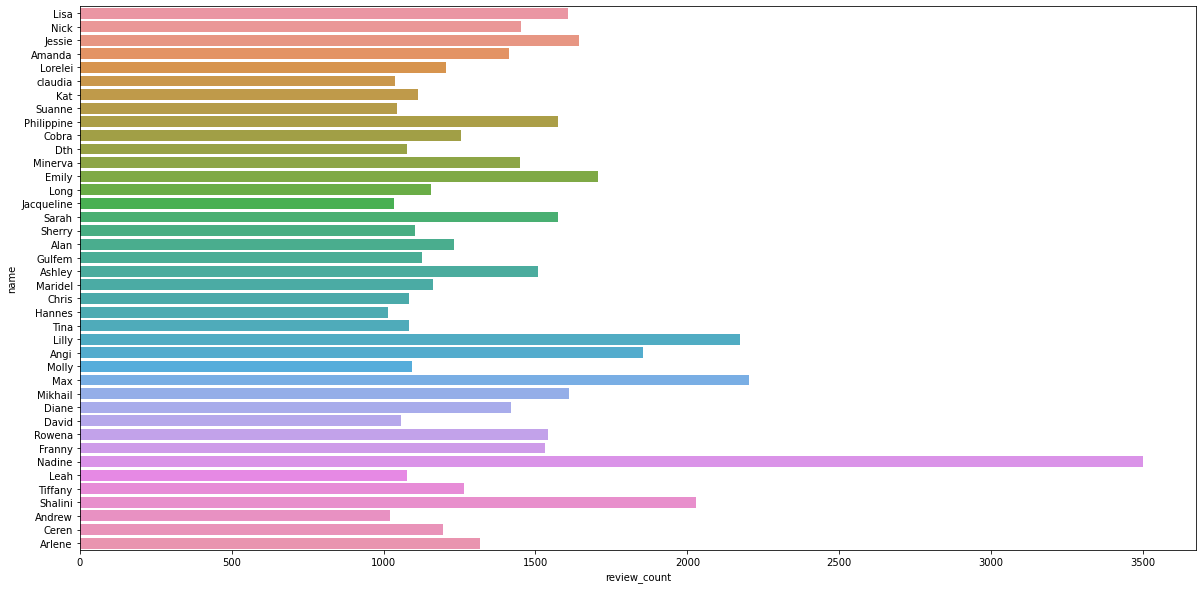

In [ ]:
plt.figure(figsize = (20,10))
sns.barplot(x=user_df.loc[user_df['review_count'] > 1000]['review_count'], y=user_df.loc[user_df['review_count'] > 1000]['name'])
plt.show()

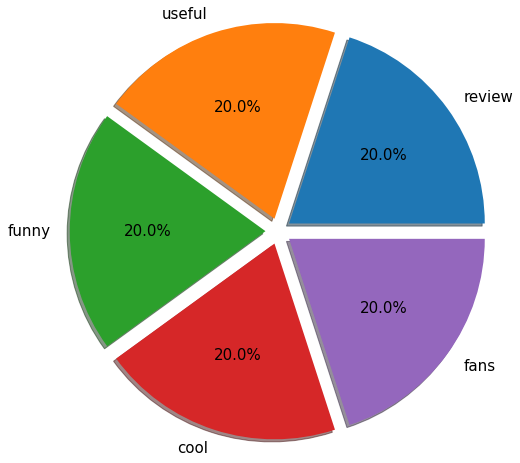

In [ ]:
review_count = user_df['review_count'].count()
useful_count = user_df['useful'].count()
funny_count = user_df['funny'].count()
cool_count = user_df['cool'].count()
fans_count = user_df['fans'].count()

plt.figure(figsize = (10,6))
plt.pie([review_count, useful_count, funny_count, cool_count, fans_count],
        autopct='%1.1f%%', labels=['review', 'useful', 'funny', 'cool', 'fans'],
        shadow=True, radius=1.5, textprops={"fontsize": 15}, explode=[0.1, 0.1, 0.1, 0.1, 0.1])
plt.show()

In [ ]:
user_df['elite'] = [0 if elite == '' else 1 for elite in user_df['elite']]
user_df.head(10)

index                 user_id        name  review_count  useful  funny  \
0  373284  Ggx8iUdJ7lsQSqXRuclXtg      Nadine          3499  110553  77755   
1  371446  VgtcRwMPiAEeuPsayXB4kA         Max          2204     852    449   
2  208533  FdPioXvctMq8lhBtd_NnTg       Lilly          2173   45204  29298   
3  375580  LWwmuZJjI4jeB95fQGbG0Q     Shalini          2030    7921   4322   
4  214761  lx71Q1-Y7xd4QSK5lUvIIA        Angi          1854    7001    379   
5  177038  UYcmGbelzRa0Q6JqzLoguw       Emily          1707   11037   5382   
6  173165  yrWJ4YZWvFj_NDOvTRaAqA      Jessie          1642    1641    861   
7  371525  CUU_SVpheVGIilr5kUaJ1Q     Mikhail          1612    5387   1696   
8    8626  HN9BbEZFK8X5QGx_C56K_g        Lisa          1606    3674   1224   
9  175664  TFpLcrl9qVptIsoUrdLZAw  Philippine          1575    6846   2912   

     cool  average_stars  elite  fans  
0  108733           4.46      1   850  
1     547           3.49      1    31  
2   42310           4.40      1   190  
3    6615           4.32      1   310  
4    3236           3.89      1   108  
5    9267           3.71      1   252  
6    1017           3.79      1   101  
7    3767           3.94      1   124  
8    2215           4.07      1   134  
9    5437           4.07      1   564

<Figure size 1440x720 with 0 Axes>

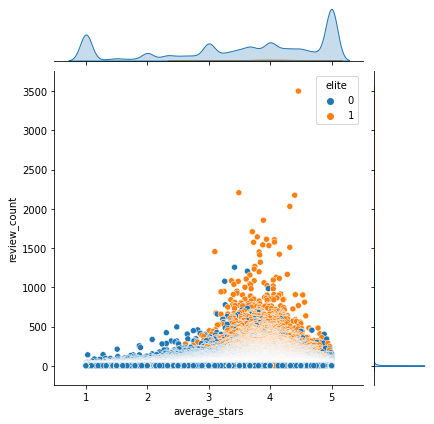

In [ ]:
plt.figure(figsize=(20,10))
sns.jointplot(x='average_stars', y='review_count',
              data = user_df, hue='elite')
plt.show()

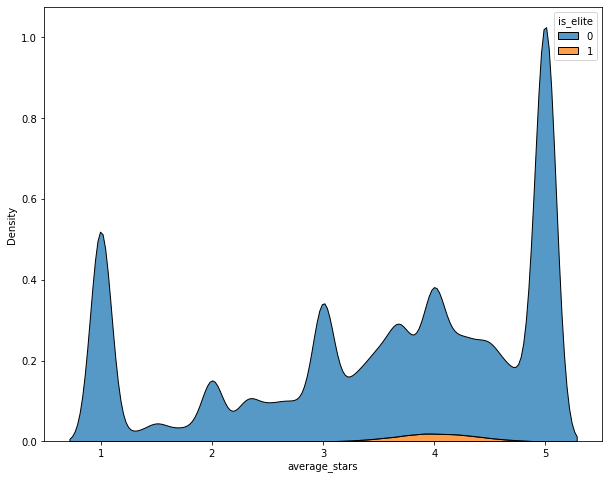

In [ ]:
plt.figure(figsize=(10,8))
sns.kdeplot(data=user_df,x='average_stars', hue="elite", multiple="stack")
plt.show()

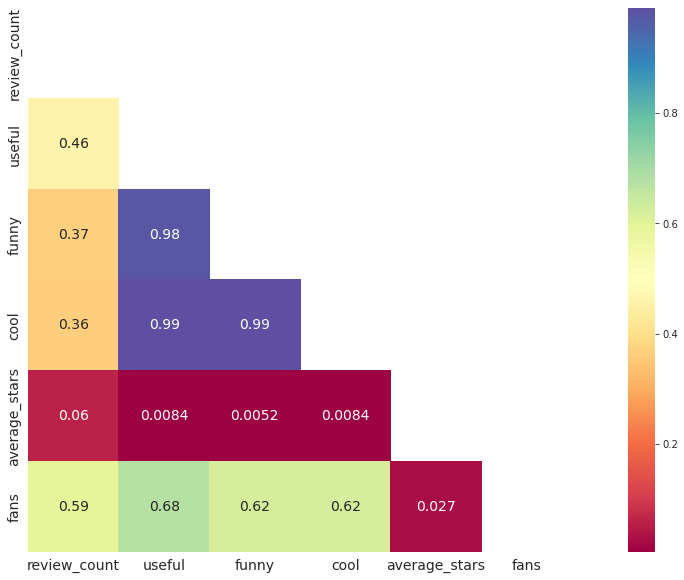

In [ ]:
#simple correlation heatmap
data = user_df[['review_count', 'useful', 'funny', 'cool', 'average_stars', 'fans']]
corrd = data.corr()

mask = np.zeros_like(corrd)
triangle_indeces = np.triu_indices_from(mask)
mask[triangle_indeces] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,10))
    ax = sns.heatmap(corrd, annot=True, cmap='Spectral', mask=mask, annot_kws = {'size': 14}, square=True)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

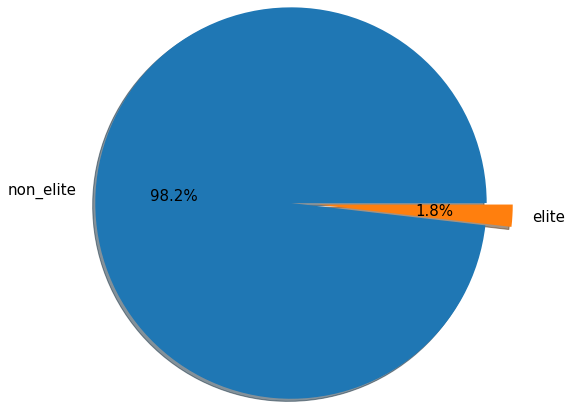

In [ ]:
non_elite_count = user_df[user_df['elite'] == 0]['user_id'].count()
elite_count = user_df[user_df['elite'] == 1]['user_id'].count()

plt.figure(figsize = (10,6))
plt.pie([non_elite_count, elite_count],
        autopct='%1.1f%%', labels=['non_elite', 'elite'],
        shadow=True, radius=1.5, textprops={"fontsize": 15}, explode=[0.1, 0.1])
plt.show()

#review_dataframe with businesses

In [ ]:
review_df = load_dataframe_from_path('review')
review_df.head()

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15

In [ ]:
#review_df.drop(columns=['date'], inplace=True)

In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372781 entries, 0 to 1372780
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   review_id    1372781 non-null  object
 1   user_id      1372781 non-null  object
 2   business_id  1372781 non-null  object
 3   stars        1372781 non-null  int64 
 4   useful       1372781 non-null  int64 
 5   funny        1372781 non-null  int64 
 6   cool         1372781 non-null  int64 
 7   text         1372781 non-null  object
dtypes: int64(4), object(4)
memory usage: 83.8+ MB


In [ ]:
review_df.shape

(1372781, 9)

In [ ]:
review_df['text length'] = review_df['text'].apply(len)
review_df.head()

review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0      3       0      0     0   
1      5       1      0     1   
2      3       0      0     0   
3      5       1      0     1   
4      4       1      0     1   

                                                text                date  \
0  If you decide to eat here, just be aware it is... 2018-07-07 22:09:11   
1  I've taken a lot of spin classes over the year... 2012-01-03 15:28:18   
2  Family diner. Had the buffet. Eclectic assortm... 2014-02-05 20:30:30   
3  Wow!  Yummy, different,  delicious.   Our favo... 2015-01-04 00:01:03   
4  Cute interior and owner (?) gave us tour of up... 2017-01-14 20:54:15   

   text length  
0          513  
1          829  
2          339  
3          243  
4          534

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Text Length Distribution')

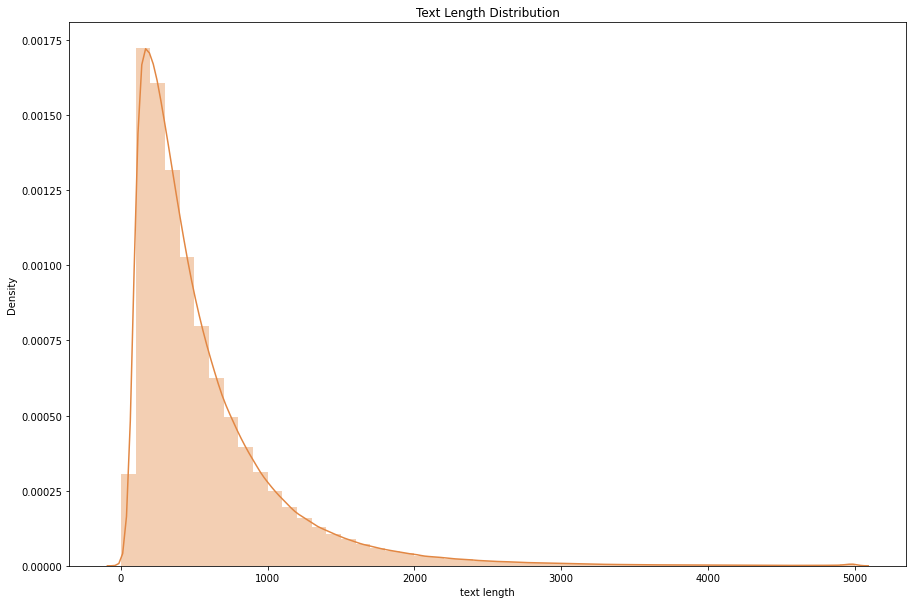

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.distplot(review_df['text length'], kde=True, bins=50, color='#e28743')
plt.title('Text Length Distribution')

Text(0, 0.5, 'count')

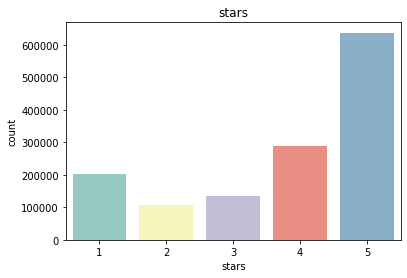

In [ ]:
cplot = sns.countplot(x='stars', data=review_df, palette="Set3")
cplot.set_title('stars')
cplot.set_ylabel('count')

In [ ]:
d_num = review_df[['stars', 'useful', 'funny', 'cool']]
stars = d_num.groupby('stars').mean()
corrd = stars.corr()
corrd

useful     funny      cool
useful  1.000000  0.789883 -0.725079
funny   0.789883  1.000000 -0.524015
cool   -0.725079 -0.524015  1.000000

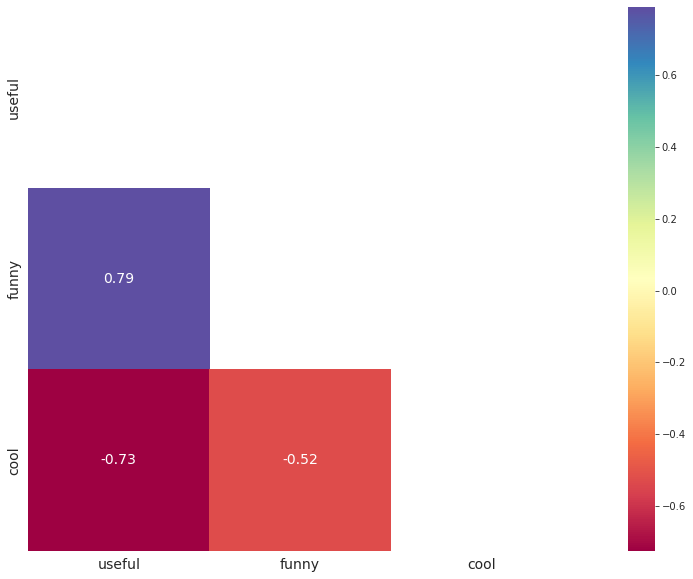

In [ ]:
mask = np.zeros_like(corrd)
triangle_indeces = np.triu_indices_from(mask)
mask[triangle_indeces] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,10))
    ax = sns.heatmap(corrd, annot=True, cmap='Spectral', mask=mask, annot_kws = {'size': 14}, square=True)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

In [ ]:
business_df = business_df[['business_id','name', 'review_count', 'latitude', 'longitude', 'is_open']]
business_df.rename(columns={'name': 'business_name'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
business_review_df = pd.merge(business_df, review_df, how='inner', left_on='business_id', right_on='business_id')
business_review_df

business_id           business_name  review_count  \
0        _aKr7POnacW_VizRKBpCiA         Blues City Deli           991   
1        _aKr7POnacW_VizRKBpCiA         Blues City Deli           991   
2        _aKr7POnacW_VizRKBpCiA         Blues City Deli           991   
3        _aKr7POnacW_VizRKBpCiA         Blues City Deli           991   
4        _aKr7POnacW_VizRKBpCiA         Blues City Deli           991   
...                         ...                     ...           ...   
1372776  BAN7ONdt7GG5syfeQgmpSw  John's Hardwood Floors             5   
1372777  BAN7ONdt7GG5syfeQgmpSw  John's Hardwood Floors             5   
1372778  BAN7ONdt7GG5syfeQgmpSw  John's Hardwood Floors             5   
1372779  BAN7ONdt7GG5syfeQgmpSw  John's Hardwood Floors             5   
1372780  BAN7ONdt7GG5syfeQgmpSw  John's Hardwood Floors             5   

          latitude  longitude  is_open               review_id  \
0        38.605024  -90.21811        1  xilt6zGZ3Nqo2_fogn3jjA   
1        38.605024  -90.21811        1  1WSjTfpqwIDCbnmzgeeXcQ   
2        38.605024  -90.21811        1  D4UUwqW7jnKX-dXfoOpmAQ   
3        38.605024  -90.21811        1  nUDifK0tE-XI1Fp2RICd0A   
4        38.605024  -90.21811        1  Egie5EM8xKR23WaYyx_xYw   
...            ...        ...      ...                     ...   
1372776  40.004884  -74.89562        1  HZVNt6BIPCAs5BvnRjCAQw   
1372777  40.004884  -74.89562        1  oAtCPfnoWXIKci7pEqtaoQ   
1372778  40.004884  -74.89562        1  3AJkQvPYywv3haqUOlPbCw   
1372779  40.004884  -74.89562        1  ijQyWOGdqcX-hYhRAw366Q   
1372780  40.004884  -74.89562        1  IysnH4N9oYMVyyrCk6u7-A   

                        user_id  stars  useful  funny  cool  \
0        u1cvQWB0lB4YsIbtSlUR7g      5       1      0     1   
1        Q8NWwNvFIXv3ssBIqElJiw      5       0      0     0   
2        RgXJC2QHvCMYBhwEvbtBZw      5       0      0     0   
3        ut8VSOb7X5OlmQSrlpcDfw      5       0      0     0   
4        zZmtOMUl1BkqADf6yDQR_A      4       0      0     0   
...                         ...    ...     ...    ...   ...   
1372776  tMfyMGwQyno2G9SRknFU4A      1       3      0     1   
1372777  AQQsIwmE-FXTPOUgFkY45Q      1       0      0     0   
1372778  xzGi50jhwVcLApJdkBwRYg      1       3      0     0   
1372779  XnXJYwqkFHtmKlxdxlGhsA      1       9      0     0   
1372780  AynXJxPB6BYe6T8LV3qOAw      1       2      0     0   

                                                      text                date  
0        By far the best deli I have ever been to in th... 2013-05-29 03:12:27  
1        Found this place on Yelp. The reviews speak fo... 2017-08-16 19:39:40  
2        Best sandwiches in St.Louis! Could eat here ev... 2018-05-28 20:23:24  
3        Great selection of sandwiches, all fresh and t... 2016-02-23 18:16:59  
4        Cute neighborhood and we found parking relativ... 2012-09-10 19:35:14  
...                                                    ...                 ...  
1372776  Save yourself a lot of stress, money and heart... 2018-05-10 01:23:16  
1372777  Very unprofessional.  In a rush. Ruined my ac ... 2021-02-02 03:54:35  
1372778  Horrible, unprofessional and unapologetic. I h... 2019-06-07 18:45:55  
1372779  Did a horrible job a few years ago. Didn't mat... 2012-11-17 01:41:48  
1372780  STOP! Reconsider before hiring this company!!!... 2020-06-16 01:35:39  

[1372781 rows x 14 columns]

In [ ]:
#user_id s in datasets are not identic
user_df = user_df[['user_id','name']]

merged_df = pd.merge(user_df, review_df, how='inner', left_on='user_id', right_on='user_id')
merged_df

Empty DataFrame
Columns: [user_id, name, review_id, business_id, stars, useful, funny, cool, text, date, text length]
Index: []

In [ ]:
business_review_df.drop(columns=['review_id', 'user_id', 'business_id'], inplace=True)
business_review_df.sort_values(by=['stars', 'review_count', 'useful'], ascending=[False, False, False], inplace=True)
business_review_df

business_name  review_count   latitude  longitude  is_open  \
366929                      Luke          4554  29.950742 -90.070416        1   
363973                      Luke          4554  29.950742 -90.070416        1   
367216                      Luke          4554  29.950742 -90.070416        1   
367099                      Luke          4554  29.950742 -90.070416        1   
367958                      Luke          4554  29.950742 -90.070416        1   
...                          ...           ...        ...        ...      ...   
1372771  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372772  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372773  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372775  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372777   John's Hardwood Floors             5  40.004884 -74.895620        1   

         stars  useful  funny  cool  \
366929       5      68     37    63   
363973       5      48     38    49   
367216       5      36     35    34   
367099       5      21     14    18   
367958       5      21      7    21   
...        ...     ...    ...   ...   
1372771      1       0      0     0   
1372772      1       0      0     0   
1372773      1       0      0     0   
1372775      1       0      0     0   
1372777      1       0      0     0   

                                                      text                date  
366929   Wow!! I found myself talking about this place ... 2019-02-12 02:38:25  
363973   Upscale bar/restaurant with an adjoining elega... 2016-01-19 21:34:15  
367216   A trip to New Orleans without trying a John Be... 2015-10-20 15:59:16  
367099   I am smitten with Lüke.\n\nDuring our whirlwin... 2010-06-21 16:23:09  
367958   While in NOLA, you must try a John Besh restau... 2017-05-23 12:30:56  
...                                                    ...                 ...  
1372771  Worst customer service ever! I have been in th... 2018-01-15 20:34:17  
1372772  Worst company ever!!  We have not had internet... 2017-07-05 17:10:51  
1372773  I keep getting spam email from a company calle... 2020-06-08 17:03:38  
1372775  Tried to upgrade service and they disconnected... 2021-06-11 17:52:11  
1372777  Very unprofessional.  In a rush. Ruined my ac ... 2021-02-02 03:54:35  

[1372781 rows x 11 columns]

In [ ]:
business_review_df.reset_index(inplace=True, drop=True)
business_review_df

business_name  review_count   latitude  longitude  is_open  \
0                           Luke          4554  29.950742 -90.070416        1   
1                           Luke          4554  29.950742 -90.070416        1   
2                           Luke          4554  29.950742 -90.070416        1   
3                           Luke          4554  29.950742 -90.070416        1   
4                           Luke          4554  29.950742 -90.070416        1   
...                          ...           ...        ...        ...      ...   
1372776  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372777  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372778  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372779  CenturyLink - St. Louis             5  38.676058 -90.402005        1   
1372780   John's Hardwood Floors             5  40.004884 -74.895620        1   

         stars  useful  funny  cool  \
0            5      68     37    63   
1            5      48     38    49   
2            5      36     35    34   
3            5      21     14    18   
4            5      21      7    21   
...        ...     ...    ...   ...   
1372776      1       0      0     0   
1372777      1       0      0     0   
1372778      1       0      0     0   
1372779      1       0      0     0   
1372780      1       0      0     0   

                                                      text                date  
0        Wow!! I found myself talking about this place ... 2019-02-12 02:38:25  
1        Upscale bar/restaurant with an adjoining elega... 2016-01-19 21:34:15  
2        A trip to New Orleans without trying a John Be... 2015-10-20 15:59:16  
3        I am smitten with Lüke.\n\nDuring our whirlwin... 2010-06-21 16:23:09  
4        While in NOLA, you must try a John Besh restau... 2017-05-23 12:30:56  
...                                                    ...                 ...  
1372776  Worst customer service ever! I have been in th... 2018-01-15 20:34:17  
1372777  Worst company ever!!  We have not had internet... 2017-07-05 17:10:51  
1372778  I keep getting spam email from a company calle... 2020-06-08 17:03:38  
1372779  Tried to upgrade service and they disconnected... 2021-06-11 17:52:11  
1372780  Very unprofessional.  In a rush. Ruined my ac ... 2021-02-02 03:54:35  

[1372781 rows x 11 columns]

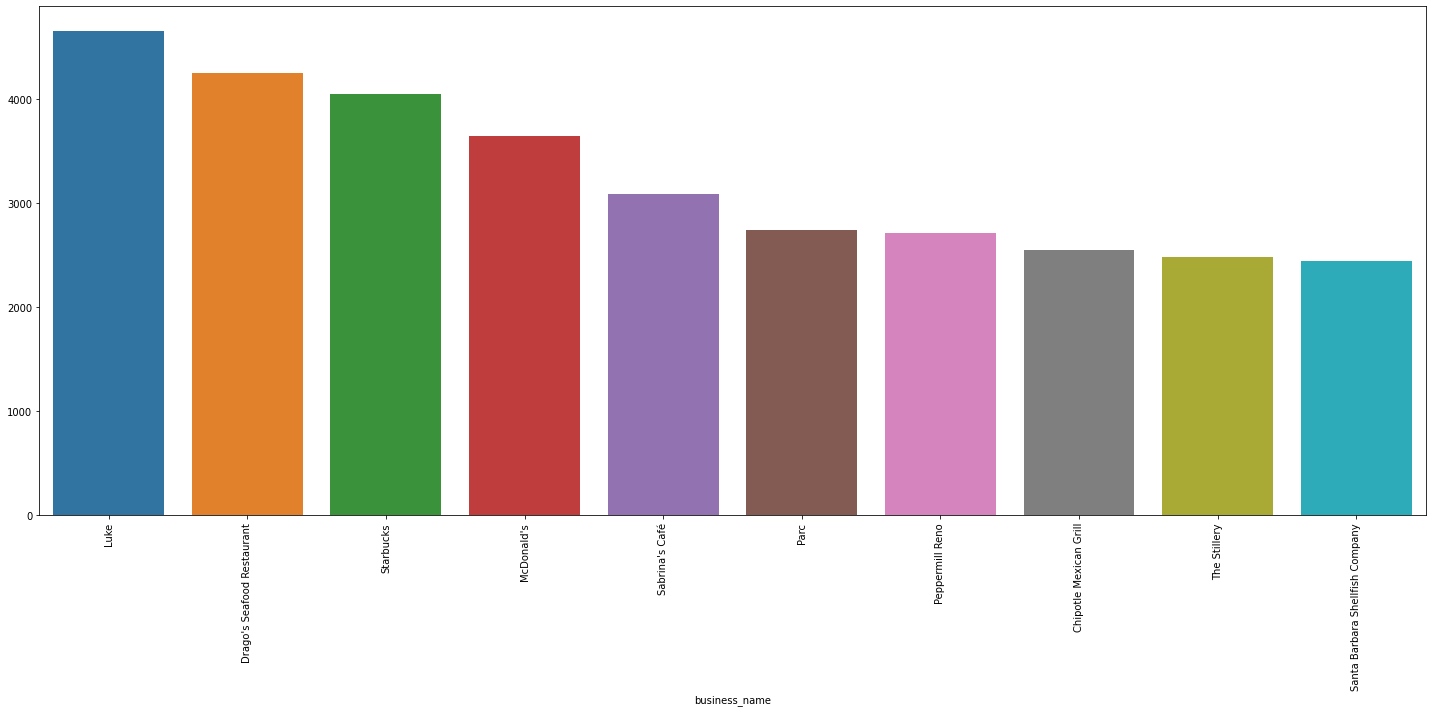

In [ ]:
business_cnt = business_review_df.groupby(['business_name'])['business_name'].count().sort_values(ascending=False)
plt.figure(figsize = (20,10))
sns.barplot(x=business_cnt[:10].index, y=business_cnt[:10].values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(business_cnt[:10].index)

business_name
0                             Luke
1       Drago's Seafood Restaurant
2                        Starbucks
3                       McDonald's
4                   Sabrina's Café
5                             Parc
6                  Peppermill Reno
7           Chipotle Mexican Grill
8                     The Stillery
9  Santa Barbara Shellfish Company

#sentiment analysys on review text

In [ ]:
df = business_review_df[['business_name', 'text']]
df.sort_values(by=['business_name'], inplace=True)
df.reset_index(inplace=True, drop=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


business_name  \
0        "No Macarena" DJ & Custom Music Service   
1        "No Macarena" DJ & Custom Music Service   
2        "No Macarena" DJ & Custom Music Service   
3        "No Macarena" DJ & Custom Music Service   
4        "No Macarena" DJ & Custom Music Service   
...                                          ...   
1372776                              ōLiv Tucson   
1372777                              ōLiv Tucson   
1372778                              ōLiv Tucson   
1372779                              ōLiv Tucson   
1372780                              ōLiv Tucson   

                                                      text  
0        We hired "No Macarena" for our wedding and we ...  
1        Jonas and No Macarena DJ were terrific! Jonas ...  
2        Kim did an absolutely wonderful job at our wed...  
3        No Macarena was affordable and easy to work wi...  
4        Kim from No Macarena DJed at our wedding last ...  
...                                                    ...  
1372776  Everything about this place feels rushed, ster...  
1372777  None of the residents are wearing masks and we...  
1372778  If you love your son or daughter, do not let t...  
1372779  This place is horrible. Management is incompet...  
1372780  Management could not be worse. I pay an absurd...  

[1372781 rows x 2 columns]

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

In [ ]:
nltk.download([
     "stopwords",
     "wordnet",
     "omw-1.4",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

In [ ]:
stopwords = set(stopwords.words("english")) - set(['no', 'not'])
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def clean_sentence(sent, stopwords = stopwords, lemmatizer = lemmatizer):

  #tokenize words
  words_in_quote = word_tokenize(str(sent))

  #clean stopwords and all the symbols
  filtered_list = [
     word.lower().strip() for word in words_in_quote if word.casefold() not in stopwords and word.isalpha() and len(word)>1
  ]

  #lemmatize
  lemmatized_list = [
      lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in filtered_list
  ]

  #return cleaned text
  return ' '.join(lemmatized_list)

In [ ]:
data = df[df['business_name'].isin(business_cnt[:10].index.values.tolist())]
data


business_name  \
258279   Chipotle Mexican Grill   
258280   Chipotle Mexican Grill   
258281   Chipotle Mexican Grill   
258282   Chipotle Mexican Grill   
258283   Chipotle Mexican Grill   
...                         ...   
1239067            The Stillery   
1239068            The Stillery   
1239069            The Stillery   
1239070            The Stillery   
1239071            The Stillery   

                                                      text  
258279   It's a busy spot no matter what time of day bu...  
258280   Best chipotle I've been to so far. \nClean. Fr...  
258281   Is everything OK with you guys in Newtown Squa...  
258282   The General Manager EMILY out thiere was a rea...  
258283   Not all Chipotles are created equal ... but th...  
...                                                    ...  
1239067  Unlike anything I have ever experienced! This ...  
1239068  Awesome. Drove down from Indy for a concert an...  
1239069  On a recent trip to Nashville for a concert, t...  
1239070  Dude......\nOh. Em. Geesus.\nThis place is my ...  
1239071  The only reason I didn't give them 5 is becaus...  

[32649 rows x 2 columns]

In [ ]:
data.reset_index(inplace=True, drop=True)
data

business_name  \
0      Chipotle Mexican Grill   
1      Chipotle Mexican Grill   
2      Chipotle Mexican Grill   
3      Chipotle Mexican Grill   
4      Chipotle Mexican Grill   
...                       ...   
32644            The Stillery   
32645            The Stillery   
32646            The Stillery   
32647            The Stillery   
32648            The Stillery   

                                                    text  
0      It's a busy spot no matter what time of day bu...  
1      Best chipotle I've been to so far. \nClean. Fr...  
2      Is everything OK with you guys in Newtown Squa...  
3      The General Manager EMILY out thiere was a rea...  
4      Not all Chipotles are created equal ... but th...  
...                                                  ...  
32644  Unlike anything I have ever experienced! This ...  
32645  Awesome. Drove down from Indy for a concert an...  
32646  On a recent trip to Nashville for a concert, t...  
32647  Dude......\nOh. Em. Geesus.\nThis place is my ...  
32648  The only reason I didn't give them 5 is becaus...  

[32649 rows x 2 columns]

In [ ]:
data['text'][0]

"Go to brunch spot in Midtown! Food/Service both always great! Got the Steak/Shroom pizza today and I can't wait to go back and have it again!"

In [ ]:
data['text'] = [str(clean_sentence(sent)) for sent in data['text']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data['text'][0]

'go brunch spot midtown always great get pizza today ca wait go back'

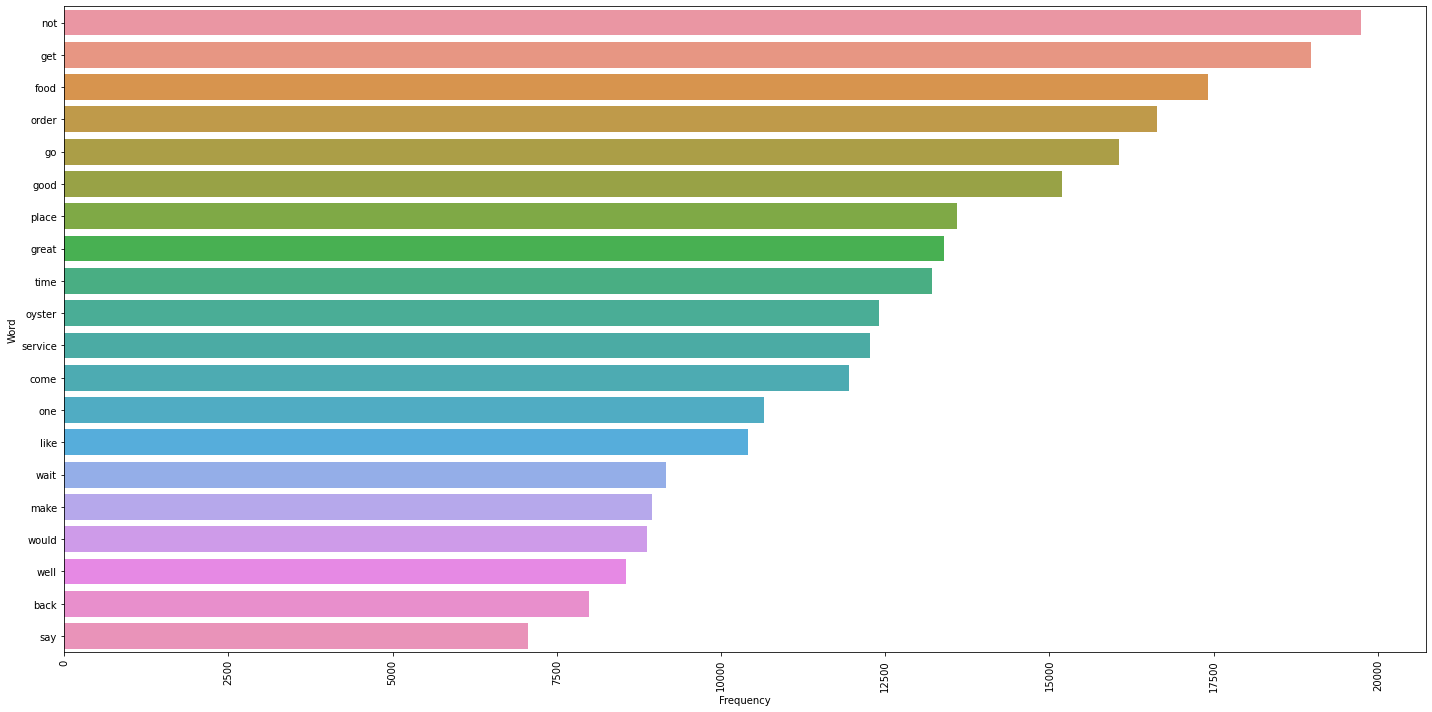

In [ ]:
words_split = []
for sent in data['text']:
  word_list = sent.split(" ")
  for word in word_list:
    words_split.append(word)

token_dist = FreqDist(words_split)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])

plt.figure(figsize = (20,10))
sns.barplot(x=dist[:20]['Frequency'], y=dist[:20]['Word'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

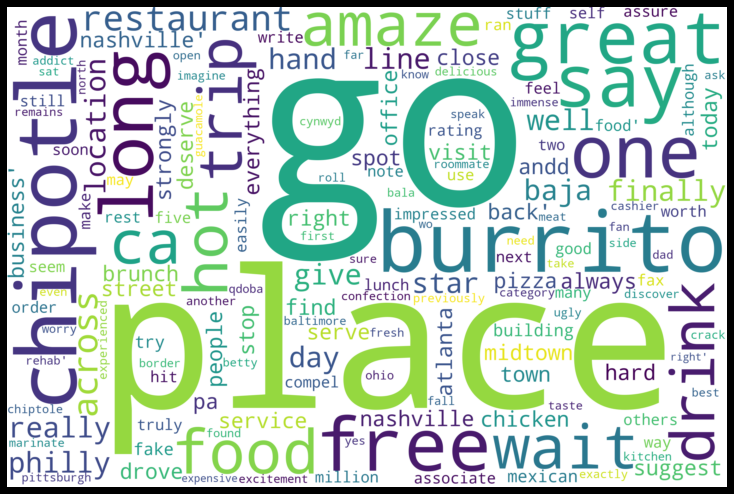

In [ ]:
review_text = data['text'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(review_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
from statistics import mean

def is_positive(business_name, data = data) -> bool:
    """True if the average of all sentence compound scores is positive."""
    text = data[data['business_name'] == business_name]['text'].values
    scores = [
        sia.polarity_scores(sentence)["compound"]
        for sentence in text
    ]
    return mean(scores) > 0

In [ ]:
the_stillery = is_positive('The Stillery')
the_stillery

True

In [ ]:
mcs = is_positive("McDonald's")
mcs

False

In [ ]:
Starbucks = is_positive('Starbucks')
Starbucks

True